In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
# Import các lớp cần thiết từ thư viện Surprise cho cell 8
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise.model_selection import GridSearchCV
from surprise import accuracy

# Thiết lập cho biểu đồ (tùy chọn)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [8]:
# Tải các biến từ file .env
load_dotenv()

# Lấy chuỗi kết nối từ biến môi trường
DATABASE_URL = os.getenv('DATABASE_URL')

if not DATABASE_URL:
    raise ValueError("DATABASE_URL not found in .env file. Please check your configuration.")

# Tạo một "engine" kết nối đến database bằng SQLAlchemy
# SQLAlchemy là một ORM mạnh mẽ cho Python, nhưng ở đây ta chỉ dùng nó để kết nối
try:
    engine = create_engine(DATABASE_URL)
    print("Database engine created successfully.")
except Exception as e:
    print(f"Failed to create database engine: {e}")

Database engine created successfully.


In [9]:
# Câu lệnh SQL để lấy các cột cần thiết từ bảng Rating
query = """
SELECT 
    "userId", 
    "movieId", 
    score 
FROM "Rating";
"""

# Sử dụng Pandas để đọc dữ liệu trực tiếp từ database
# Quá trình này có thể mất 10-20 giây
print("Loading ratings data from database...")
try:
    ratings_df = pd.read_sql(query, engine)
    print("Data loaded successfully!")
    
    # Hiển thị 5 dòng đầu tiên để kiểm tra
    display(ratings_df.head())
    
    # Hiển thị thông tin tổng quan về DataFrame
    print("\nDataFrame Info:")
    ratings_df.info()

except Exception as e:
    print(f"Failed to load data: {e}")

Loading ratings data from database...
Data loaded successfully!


,userId,movieId,score
0,fef77507-5d6c-4ed1-9843-a2e699906acb,862,4
1,fef77507-5d6c-4ed1-9843-a2e699906acb,15602,4
2,fef77507-5d6c-4ed1-9843-a2e699906acb,949,4
3,fef77507-5d6c-4ed1-9843-a2e699906acb,807,5
4,fef77507-5d6c-4ed1-9843-a2e699906acb,629,5



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100794 entries, 0 to 100793
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   userId   100794 non-null  object
 1   movieId  100794 non-null  int64 
 2   score    100794 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


In [21]:
print("Basic Descriptive Statistics for Ratings:")
print("ratings_df exists:", 'ratings_df' in globals())
display(ratings_df['score'].describe())

print(f"\nTotal number of unique users: {ratings_df['userId'].nunique()}")
print(f"Total number of unique movies: {ratings_df['movieId'].nunique()}")

# Tính độ thưa (sparsity) của ma trận
n_users = ratings_df['userId'].nunique()
n_movies = ratings_df['movieId'].nunique()
n_ratings = len(ratings_df)
sparsity = 1 - (n_ratings / (n_users * n_movies))
print(f"Sparsity of the user-item matrix: {sparsity:.2%}")

Basic Descriptive Statistics for Ratings:
ratings_df exists: True


count    100794.000000
mean          3.652231
std           1.045105
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: score, dtype: float64


Total number of unique users: 611
Total number of unique movies: 9703
Sparsity of the user-item matrix: 98.30%


C:\Users\Admin\AppData\Local\Temp\ipykernel_68548\671684547.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='score', data=ratings_df, palette='viridis')


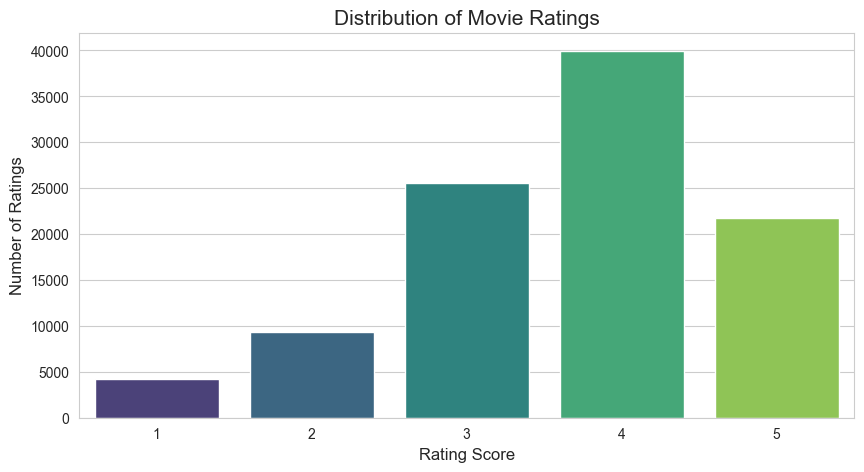

In [22]:
plt.figure(figsize=(10, 5))
sns.countplot(x='score', data=ratings_df, palette='viridis')
plt.title('Distribution of Movie Ratings', fontsize=15)
plt.xlabel('Rating Score', fontsize=12)
plt.ylabel('Number of Ratings', fontsize=12)
plt.show()

Thấy rằng điểm 4 thường là cột cao nhất, tiếp theo là 3 và 5. Điểm 1 và 2 ít hơn. Điều này cho thấy người dùng có xu hướng đánh giá những phim họ thích.

Loading movies data from database...

Top 10 Most Rated Movies:


title
Forrest Gump                  329
Shawshank Redemption, The     317
Pulp Fiction                  307
Silence of the Lambs, The     279
Matrix, The                   278
Star Wars                     251
Jurassic Park                 238
Braveheart                    237
Terminator 2: Judgment Day    224
Schindler's List              220
Name: count, dtype: int64

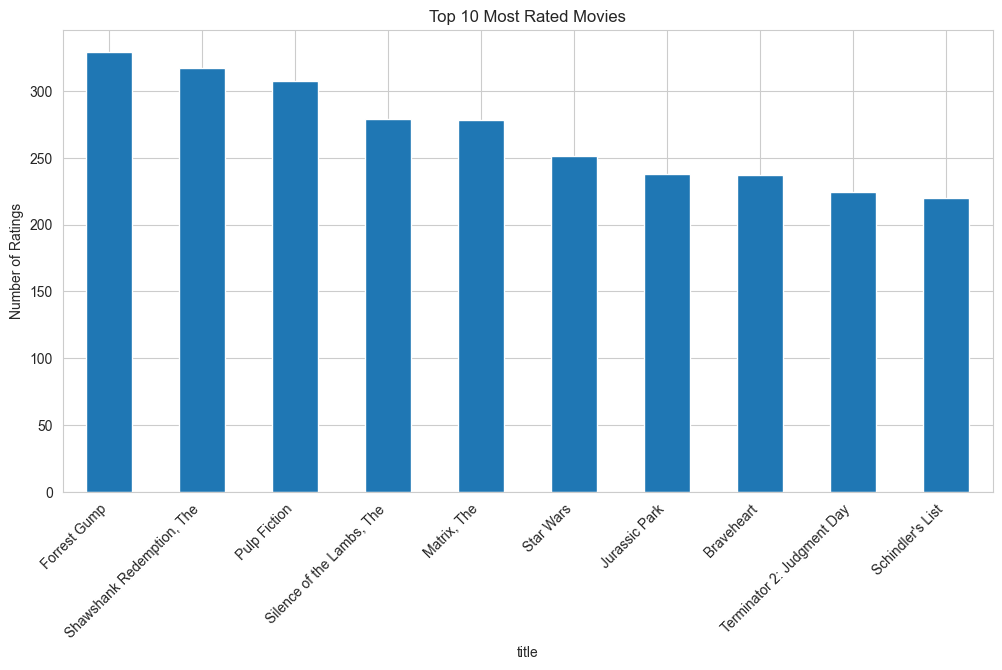

In [23]:
# Để hiển thị tên phim, chúng ta cần tải thêm bảng `Movie`
print("Loading movies data from database...")
movies_df = pd.read_sql('SELECT id, title FROM "Movie";', engine)

# Gộp (merge) hai DataFrame lại với nhau
movie_ratings_df = pd.merge(ratings_df, movies_df, left_on='movieId', right_on='id')

# Đếm số lần xuất hiện của mỗi phim
movie_rating_counts = movie_ratings_df['title'].value_counts()

print("\nTop 10 Most Rated Movies:")
display(movie_rating_counts.head(10))

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
movie_rating_counts.head(10).plot(kind='bar')
plt.title('Top 10 Most Rated Movies')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45, ha='right')
plt.show()


Statistics for number of ratings per user:


count     611.000000
mean      164.965630
std       269.212422
min         1.000000
25%        35.000000
50%        70.000000
75%       168.000000
max      2697.000000
Name: count, dtype: float64

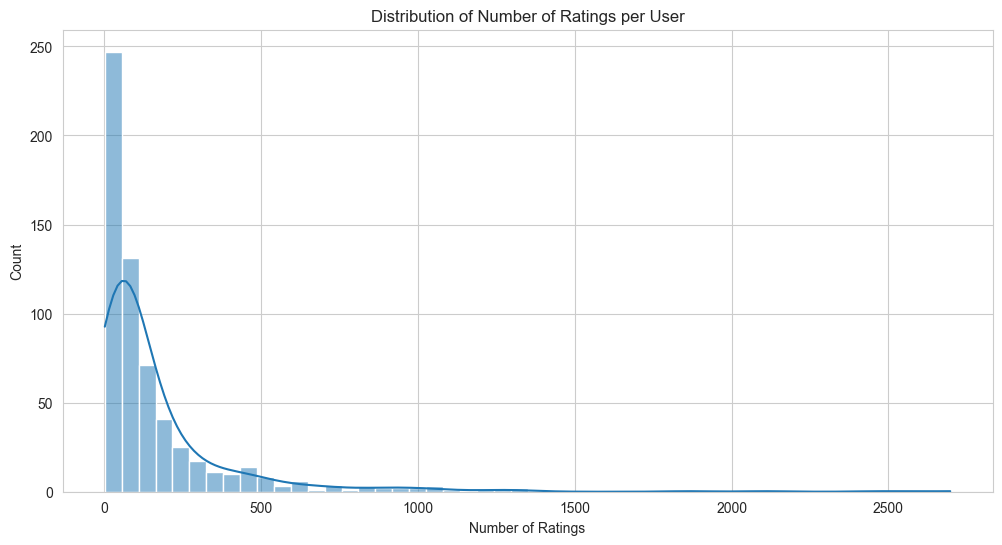

In [24]:
user_rating_counts = ratings_df['userId'].value_counts()

print("\nStatistics for number of ratings per user:")
display(user_rating_counts.describe())

# Vẽ biểu đồ phân phối
plt.figure(figsize=(12, 6))
sns.histplot(user_rating_counts, bins=50, kde=True)
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.show()

Thấy rằng hầu hết người dùng chỉ đánh giá một số lượng nhỏ phim, trong khi có một vài "super user" đánh giá rất nhiều. Đây là một đặc điểm phổ biến của các hệ thống gợi ý.


Người có ít đánh giá sẽ khó dự đoán (cold start).

Người có nhiều đánh giá có thể ảnh hưởng mạnh đến mô hình.

In [25]:


# Bước 1: Định nghĩa "Người đọc" (Reader)
# Chúng ta cần nói cho Surprise biết thang điểm đánh giá của chúng ta là từ 1 đến 5.
reader = Reader(rating_scale=(1, 5))

# Bước 2: Tải dữ liệu từ DataFrame vào Dataset của Surprise
# Surprise chỉ cần 3 cột theo đúng thứ tự: user, item, rating.
# Chúng ta sẽ dùng DataFrame `ratings_df` đã tải ở bước đầu.
print("Loading data into Surprise's Dataset format...")
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'score']], reader)
print("Data loaded successfully.")

Loading data into Surprise's Dataset format...
Data loaded successfully.


In [26]:
# Chia dữ liệu theo tỉ lệ 80% cho huấn luyện/validation và 20% cho kiểm thử.
# `random_state` đảm bảo rằng mỗi lần bạn chạy lại code, kết quả chia đều giống hệt nhau.
trainval_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

print(f"Total number of ratings: {len(ratings_df)}")
# Để lấy số lượng ratings trong một set của Surprise, ta dùng .all_ratings()
print(f"Number of ratings in Train/Validation set (80%): {len(list(trainval_set.all_ratings()))}")
print(f"Number of ratings in Test set (20%): {len(test_set)}")

Total number of ratings: 100794
Number of ratings in Train/Validation set (80%): 80635
Number of ratings in Test set (20%): 20159


In [27]:
# Surprise có một phương thức đặc biệt để tạo ra một "trainset" từ toàn bộ dataset.
# Đây là tập dữ liệu chúng ta sẽ dùng để huấn luyện mô hình sản phẩm.
print("\nBuilding full trainset for final model retraining...")
full_trainset = data.build_full_trainset()
print("Full trainset built successfully.")


Building full trainset for final model retraining...
Full trainset built successfully.


In [28]:
print("=== BƯỚC 2: HYPERPARAMETER TUNING ===")

# Tạo Dataset từ 80% data (trainval_set)
print("Converting trainval_set to Dataset format...")
trainval_raw_ratings = list(trainval_set.all_ratings())
trainval_df = pd.DataFrame(trainval_raw_ratings, columns=['userId', 'movieId', 'score'])

# Tạo Dataset mới từ 80% data
reader = Reader(rating_scale=(1, 5))
trainval_data = Dataset.load_from_df(trainval_df, reader)
print("Trainval Dataset created successfully!")

# Định nghĩa lưới tham số
param_grid = {
    'n_factors': [50, 100],      # Số lượng "đặc tính ẩn" (latent factors)
    'n_epochs': [20, 30],        # Số lần lặp qua toàn bộ dữ liệu để học
    'lr_all': [0.005, 0.01],     # Tốc độ học (learning rate)
    'reg_all': [0.02, 0.1]       # Tham số chống "học vẹt" (regularization)
}

# Khởi tạo GridSearchCV
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5, n_jobs=-1)

# FIT GridSearchCV chỉ trên 80% data với K-fold CV
print("Starting GridSearchCV on 80% data with 5-fold CV...")
print("This may take several minutes...")
gs.fit(trainval_data)  # ✅ Chỉ dùng 80% data

# Kết quả tốt nhất
print("\n--- GridSearchCV Results ---")
print(f"Best RMSE score: {gs.best_score['rmse']:.4f}")
print("Best parameters found:")
print(gs.best_params['rmse'])

best_svd_model = gs.best_estimator['rmse']
print("\n✅ Best SVD model selected!")

=== BƯỚC 2: HYPERPARAMETER TUNING ===
Converting trainval_set to Dataset format...
Trainval Dataset created successfully!
Starting GridSearchCV on 80% data with 5-fold CV...
This may take several minutes...

--- GridSearchCV Results ---
Best RMSE score: 0.8757
Best parameters found:
{'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}

✅ Best SVD model selected!


In [29]:
print("=== BƯỚC 3: ĐÁNH GIÁ TRÊN TEST SET ===")

# Huấn luyện mô hình tốt nhất trên 80% data
print("Training best model on 80% trainval data...")
best_svd_model.fit(trainval_set)

# Đánh giá trên 20% test set
print("Evaluating on 20% test set...")
test_predictions = best_svd_model.test(test_set)

# Tính các chỉ số đánh giá
test_rmse = accuracy.rmse(test_predictions, verbose=True)
test_mae = accuracy.mae(test_predictions, verbose=True)

print(f"\n=== FINAL TEST RESULTS ===")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print("✅ Model evaluation completed!")

=== BƯỚC 3: ĐÁNH GIÁ TRÊN TEST SET ===
Training best model on 80% trainval data...
Evaluating on 20% test set...
RMSE: 0.8609
MAE:  0.6687

=== FINAL TEST RESULTS ===
Test RMSE: 0.8609
Test MAE: 0.6687
✅ Model evaluation completed!


In [30]:
print("=== BƯỚC 4: MÔ HÌNH SẢN PHẨM (100% DATA) ===")

# Tạo mô hình sản phẩm với tham số tốt nhất
best_params = gs.best_params['rmse']
print(f"Creating production model with best params:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

production_model = SVD(**best_params)

# Huấn luyện trên 100% dữ liệu
print("\nTraining production model on 100% data...")
production_model.fit(full_trainset)
print("✅ Production model trained successfully!")

# Thông tin mô hình
print(f"\nProduction Model Info:")
print(f"  - Users: {full_trainset.n_users}")
print(f"  - Items: {full_trainset.n_items}")
print(f"  - Ratings: {full_trainset.n_ratings}")
print(f"  - Best Test RMSE: {test_rmse:.4f}")

=== BƯỚC 4: MÔ HÌNH SẢN PHẨM (100% DATA) ===
Creating production model with best params:
  n_factors: 100
  n_epochs: 30
  lr_all: 0.01
  reg_all: 0.1

Training production model on 100% data...
✅ Production model trained successfully!

Production Model Info:
  - Users: 611
  - Items: 9703
  - Ratings: 100794
  - Best Test RMSE: 0.8609


In [32]:
print("=== SAVING PRODUCTION MODEL ===")

# Import thư viện cần thiết
import pickle
from surprise import dump
import json

# Lưu bằng Surprise dump (khuyến nghị)
model_path = 'svd_production_model'
dump.dump(model_path, predictions=None, algo=production_model)
print(f"✅ Model saved: {model_path}")

# Lưu bằng pickle (backup)
with open('svd_production_model.pkl', 'wb') as f:
    pickle.dump(production_model, f)
print("✅ Backup saved: svd_production_model.pkl")

# Lưu thông tin mô hình
model_info = {
    'best_params': best_params,
    'test_rmse': float(test_rmse),
    'test_mae': float(test_mae),
    'training_data_size': full_trainset.n_ratings,
    'n_users': full_trainset.n_users,
    'n_items': full_trainset.n_items,
    'sparsity': f"{sparsity:.2%}",
    'timestamp': pd.Timestamp.now().isoformat()
}

with open('model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)
print("✅ Model info saved: model_info.json")

=== SAVING PRODUCTION MODEL ===
✅ Model saved: svd_production_model
✅ Backup saved: svd_production_model.pkl
✅ Model info saved: model_info.json
